<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/eeg_mac_non_fl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of anesthetic concentration from EEG
In this example, we will build a model to predict anesthetic concentration (age-related MAC) from EEG during Sevoflurane anesthesia.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below.
</b> If you do not agree, please close this window.
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

## Required libraries

In [ ]:
!pip install vitaldb
import vitaldb
import random
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 8.4 MB/s eta 0:00:00


## Preprocessing

In [ ]:
SRATE = 128  # in hz
SEGLEN = 4 * SRATE  # segment samples
MAX_CASES = 100

df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track information
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # patient information

# track names and column order when loading data
track_names = ['BIS/EEG1_WAV', 'Primus/EXP_SEVO', 'BIS/BIS']
EEG = 0
SEVO = 1
BIS = 2

# Inclusion & Exclusion criteria
caseids = set(df_cases.loc[df_cases['age'] > 18, 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/EEG1_WAV', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/BIS', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_SEVO', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_DES', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_CE', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN50_CE', 'caseid'])
caseids = list(caseids)
print(f'Total {len(caseids)} cases found')
#random.shuffle(caseids)

x = []  # eeg
y = []  # sevo
b = []  # bis
c = []  # caseids
icase = 0  # number of loaded cases
for caseid in caseids:
    print(f'loading caseid={caseid} ({icase + 1}/{MAX_CASES})', end='...', flush=True)

    # extract data
    vals = vitaldb.load_case(caseid, track_names, 1 / SRATE)
    if np.nanmax(vals[:, SEVO]) < 1:
        print('all sevo < 1%')
        continue

    # convert etsevo to the age related mac
    age = df_cases.loc[df_cases['caseid'] == caseid, 'age'].values[0]
    vals[:, SEVO] /= 1.80 * 10 ** (-0.00269 * (age - 40))

    # exclude cases without bis
    if not np.any(vals[:, BIS] > 0):
        print('all bis <= 0')
        continue

    # exclude cases with use of SEVO shorter than 30 min
    valid_idx = np.where(vals[:, SEVO] > 0.1)[0]
    first_idx = valid_idx[0]
    last_idx = valid_idx[-1]
    if last_idx - first_idx < 1800 * SRATE:
        print('len sevo < 30 min')
        continue
    vals[:first_idx, SEVO] = 0

    # trim cases with BIS
    valid_idx = np.where(vals[:, BIS] > 0)[0]
    first_idx = valid_idx[0]
    last_idx = valid_idx[-1]
    vals = vals[first_idx:last_idx + 1, :]

    # exclude cases shorter than 30 min
    if len(vals) < 1800 * SRATE:
        print('len bis < 30 min')
        continue

    # forward fill in MAC value and BIS value up to 7 sec
    vals[:, SEVO:] = pd.DataFrame(vals[:, SEVO:]).ffill(limit=7*SRATE).values

    # extract segments
    oldlen = len(y)
    for isamp in range(SEGLEN, len(vals), 2 * SRATE):
        bis = vals[isamp, BIS]
        mac = vals[isamp, SEVO]
        if np.isnan(bis) or np.isnan(mac) or bis == 0:
            continue
        # add to dataset
        eeg = vals[isamp - SEGLEN:isamp, EEG]
        x.append(eeg)
        y.append(mac)
        b.append(bis)
        c.append(caseid)

    # print results
    icase += 1
    print(f'{len(y) - oldlen} segments read -> total {len(y)} segments ({icase}/{MAX_CASES})')
    if icase >= MAX_CASES:
        break

# Change the input dataset to a numpy array
x = np.array(x)
y = np.array(y)
b = np.array(b)
c = np.array(c)

Total 1518 cases found
loading caseid=2 (1/100)...7277 segments read -> total 7277 segments (1/100)
loading caseid=4 (2/100)...9860 segments read -> total 17137 segments (2/100)
loading caseid=10 (3/100)...10049 segments read -> total 27186 segments (3/100)
loading caseid=12 (4/100)...14683 segments read -> total 41869 segments (4/100)
loading caseid=18 (5/100)...all bis <= 0
loading caseid=21 (5/100)...5637 segments read -> total 47506 segments (5/100)
loading caseid=24 (6/100)...2496 segments read -> total 50002 segments (6/100)
loading caseid=25 (7/100)...6741 segments read -> total 56743 segments (7/100)
loading caseid=27 (8/100)...8015 segments read -> total 64758 segments (8/100)
loading caseid=33 (9/100)...1927 segments read -> total 66685 segments (9/100)
loading caseid=43 (10/100)...6864 segments read -> total 73549 segments (10/100)
loading caseid=49 (11/100)...len sevo < 30 min
loading caseid=56 (11/100)...13725 segments read -> total 87274 segments (11/100)
loading caseid=5

## Filtering input data

In [ ]:
# exclude segments
print('invalid samples...', end='', flush=True)
valid_mask = ~(np.max(np.isnan(x), axis=1) > 0) #if there is nan
valid_mask &= (np.nanmax(x, axis=1) - np.nanmin(x, axis=1) > 12)  #bis impedence check
valid_mask &= (np.nanmax(np.abs(x), axis=1) < 100)  # noisy sample
x = x[valid_mask]
y = y[valid_mask]
b = b[valid_mask]
c = c[valid_mask]
print(f'{100*(1-np.mean(valid_mask)):.1f}% removed')

invalid samples...

<ipython-input-4-745b83bc67e2>:4: RuntimeWarning: All-NaN slice encountered
  valid_mask &= (np.nanmax(x, axis=1) - np.nanmin(x, axis=1) > 12)  #bis impedence check
<ipython-input-4-745b83bc67e2>:5: RuntimeWarning: All-NaN slice encountered
  valid_mask &= (np.nanmax(np.abs(x), axis=1) < 100)  # noisy sample


12.7% removed


## Splitting samples into training and testing dataset

In [ ]:
# caseid
caseids = list(np.unique(c))
#random.shuffle(caseids)

# Split dataset into training and testing data
ntest = max(1, int(len(caseids) * 0.2))
caseids_train = caseids[ntest:]
caseids_test = caseids[:ntest]

train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)
x_train = x[train_mask]
y_train = y[train_mask]
x_test = x[test_mask]
y_test = y[test_mask]
b_test = b[test_mask]
c_test = c[test_mask]

print('====================================================')
print(f'total: {len(caseids)} cases {len(y)} samples')
print(f'train: {len(np.unique(c[train_mask]))} cases {len(y_train)} samples')
print(f'test {len(np.unique(c_test))} cases {len(y_test)} samples')
print('====================================================')

total: 100 cases 496346 samples
train: 80 cases 384419 samples
test 20 cases 111927 samples


In [ ]:
x_train.shape

(384419, 512)

## Modeling and Evaluation

In [ ]:
"""import keras.models
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential




out = inp = Input(shape=(x_train.shape[1], 1))
for i in range(4):
    out = Conv1D(filters=32, kernel_size=7, padding='same')(out)
    out = Activation('relu')(out)
    out = MaxPooling1D(2, padding='same')(out)
out = GlobalMaxPooling1D()(out)
out = Dense(128)(out)
out = Dropout(0.2)(out)
out = Dense(1)(out)

model = Model(inputs=[inp], outputs=[out])
model.summary()


model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])



# fit model. the last 20% of the segments will be used for early stopping
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=4096,
                callbacks=[ModelCheckpoint(monitor='val_loss', filepath='model.x', verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')])
"""

In [ ]:
import os
import numpy as np
import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5))


# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

NameError: ignored

In [ ]:
# fit model. the last 20% of the segments will be used for early stopping
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=4096,
                callbacks=[ModelCheckpoint(monitor='val_loss', filepath='model.x', verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')])



In [ ]:


# prediction
pred_test = model.predict(x_test).flatten()
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    pred_test[case_mask] = scipy.signal.medfilt(pred_test[case_mask], 15)

3498/3498 [==============================] - 13s 2ms/step


In [ ]:

# calculate the performance
test_mae = np.mean(np.abs(y_test - pred_test))

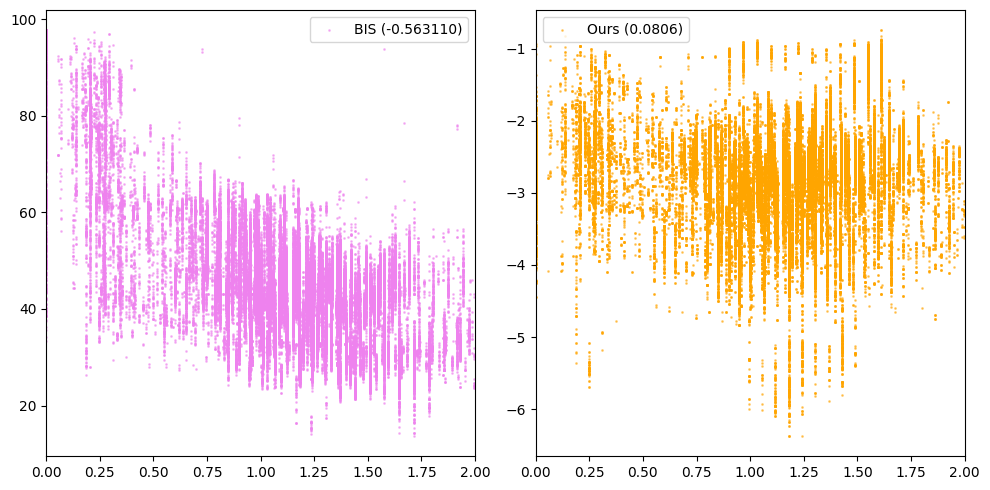

In [ ]:
# pearson correlation coefficient
bis_corr = np.corrcoef(y_test, b_test)[0, 1]
our_corr = np.corrcoef(y_test, pred_test)[0, 1]

# scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, b_test, s=1, alpha=0.5, c='violet', label=f'BIS ({bis_corr:4f})')
plt.xlim([0, 2])
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test, s=1, alpha=0.5, c='orange', label=f'Ours ({our_corr:.4f})')
plt.xlim([0, 2])
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Total MAE=3.9884, CaseID 2, MAE=3.9757


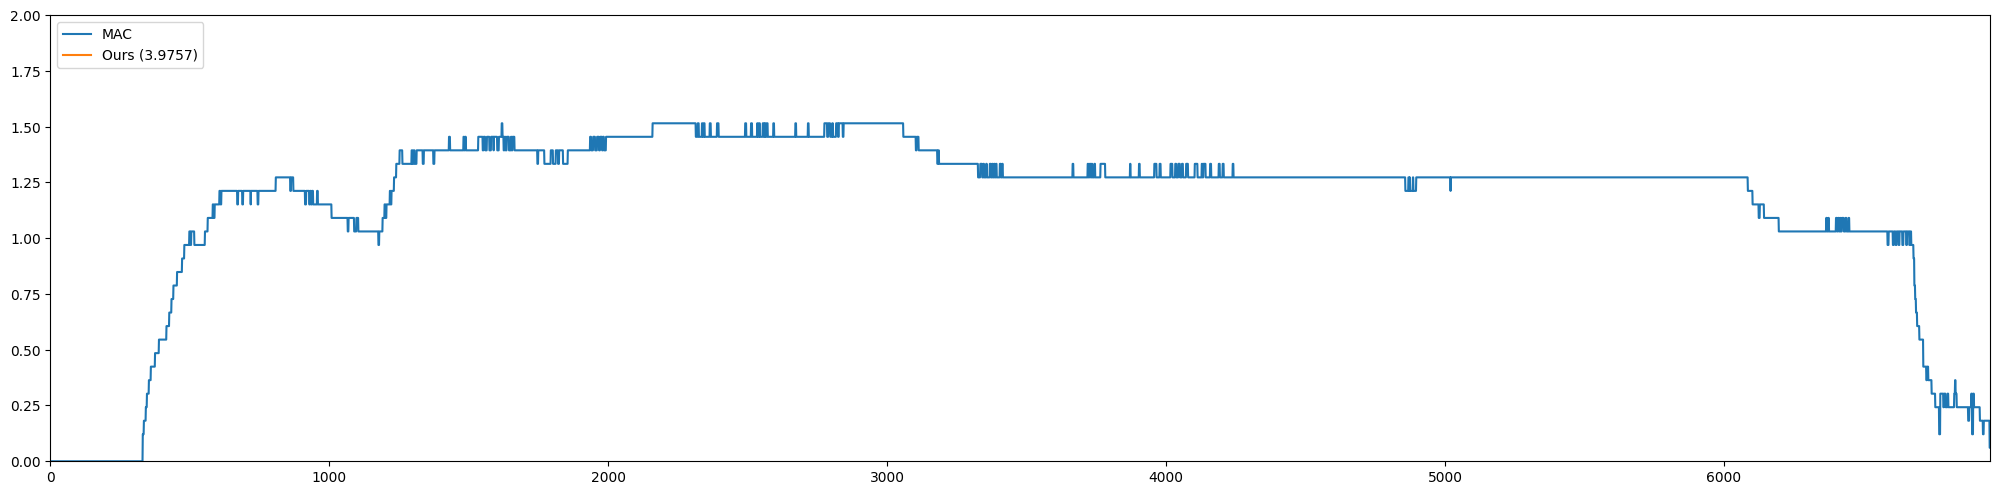

Total MAE=3.9884, CaseID 4, MAE=3.8758


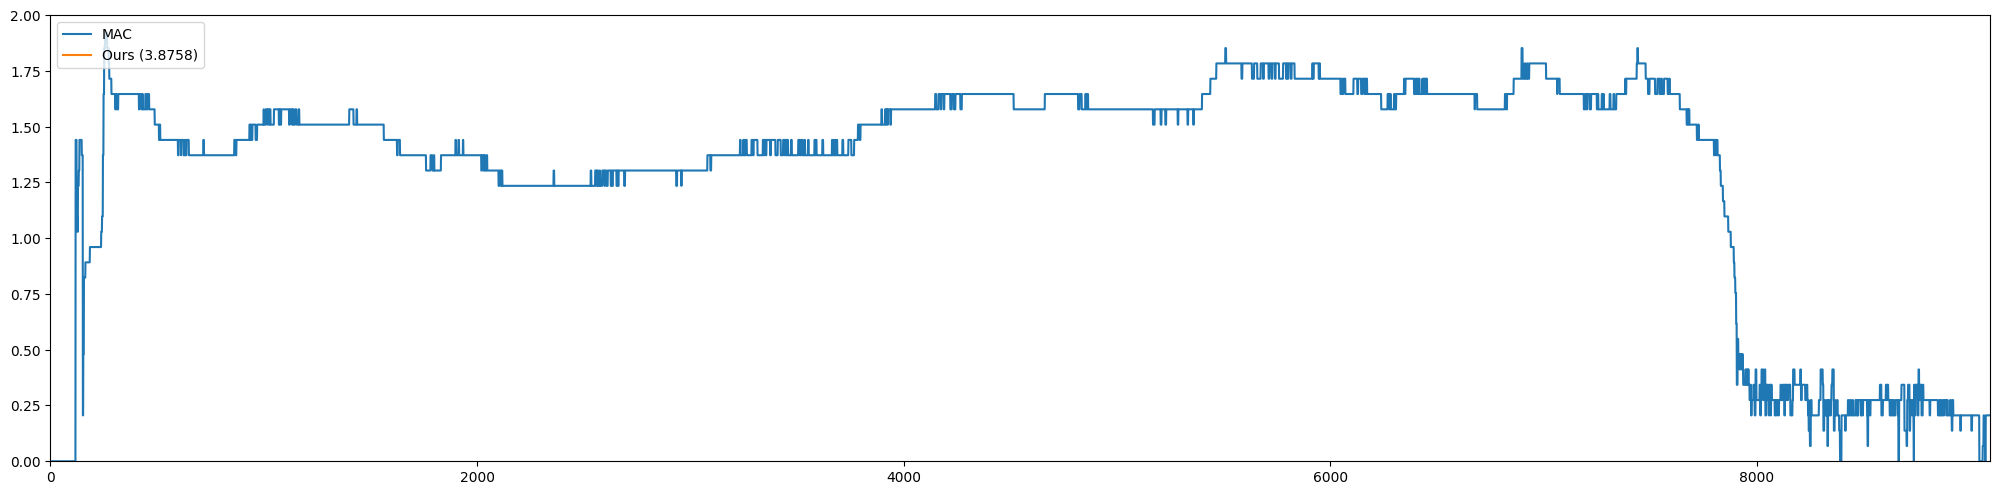

Total MAE=3.9884, CaseID 10, MAE=3.9548


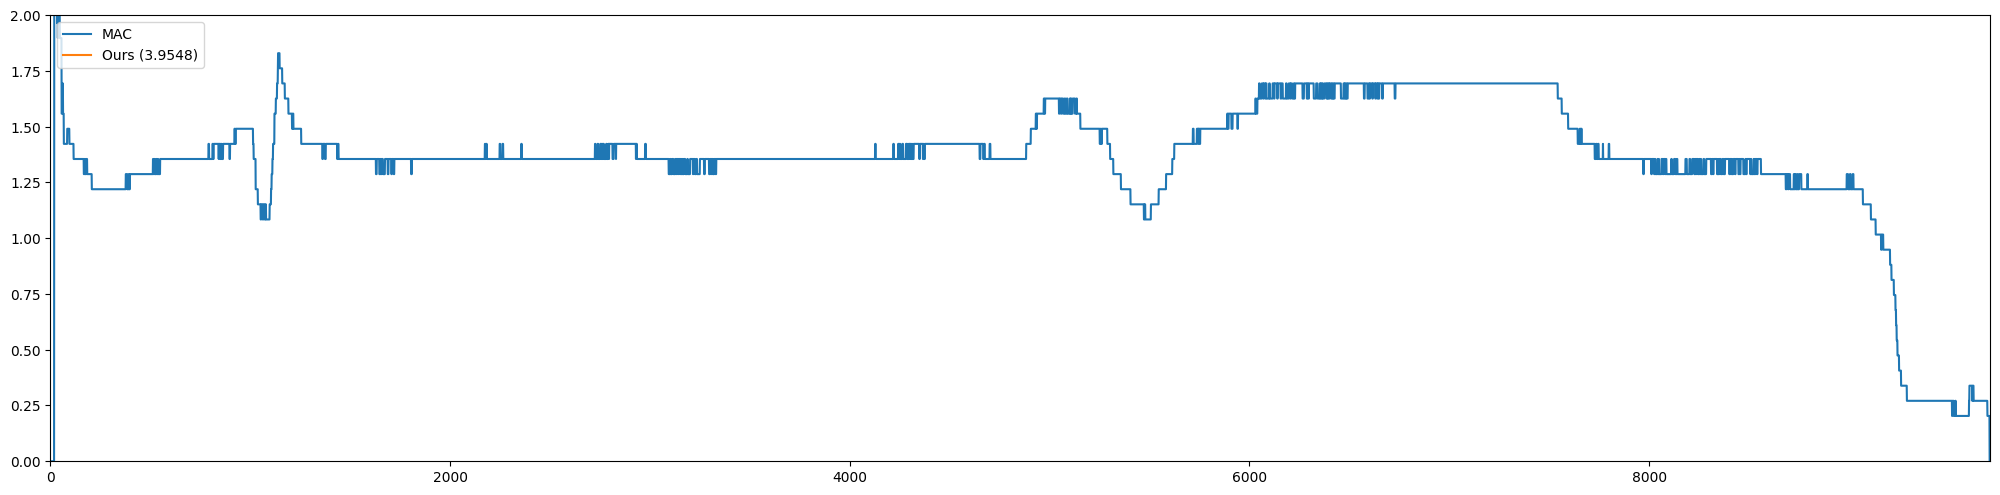

Total MAE=3.9884, CaseID 12, MAE=3.5468


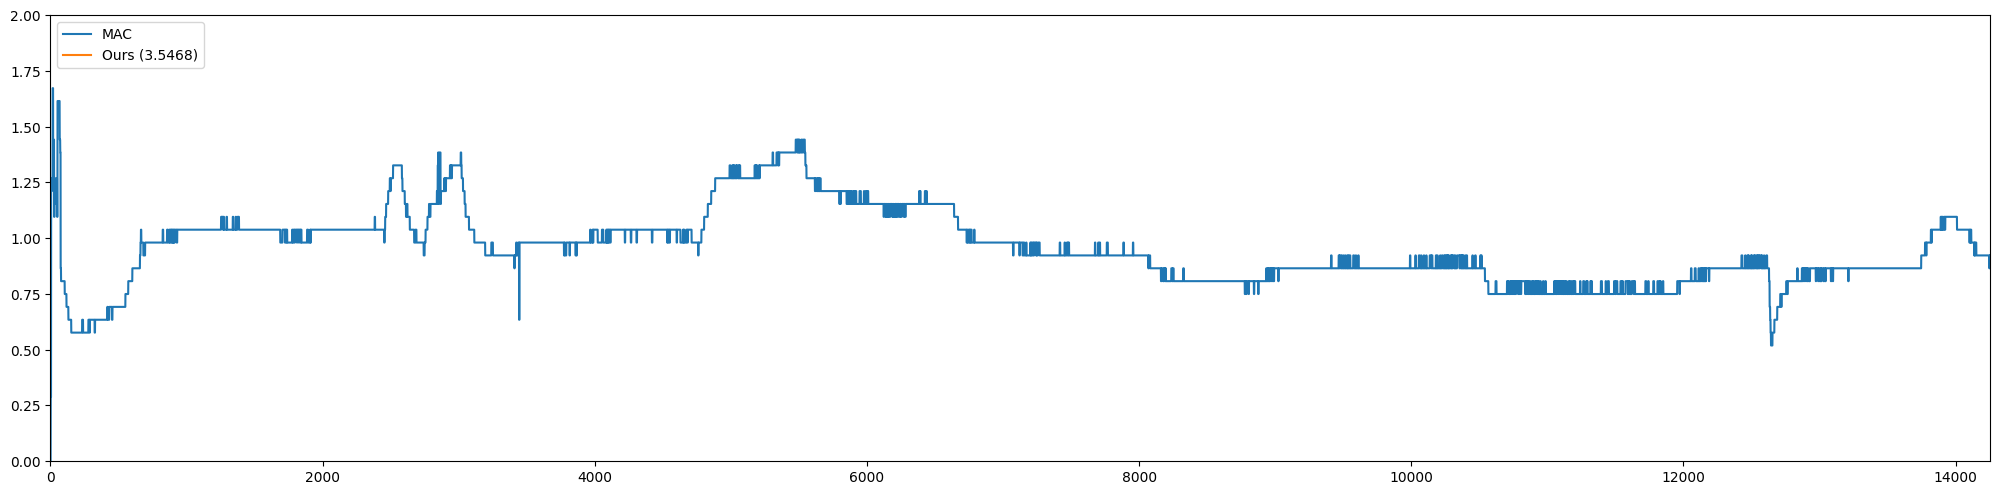

Total MAE=3.9884, CaseID 21, MAE=4.7776


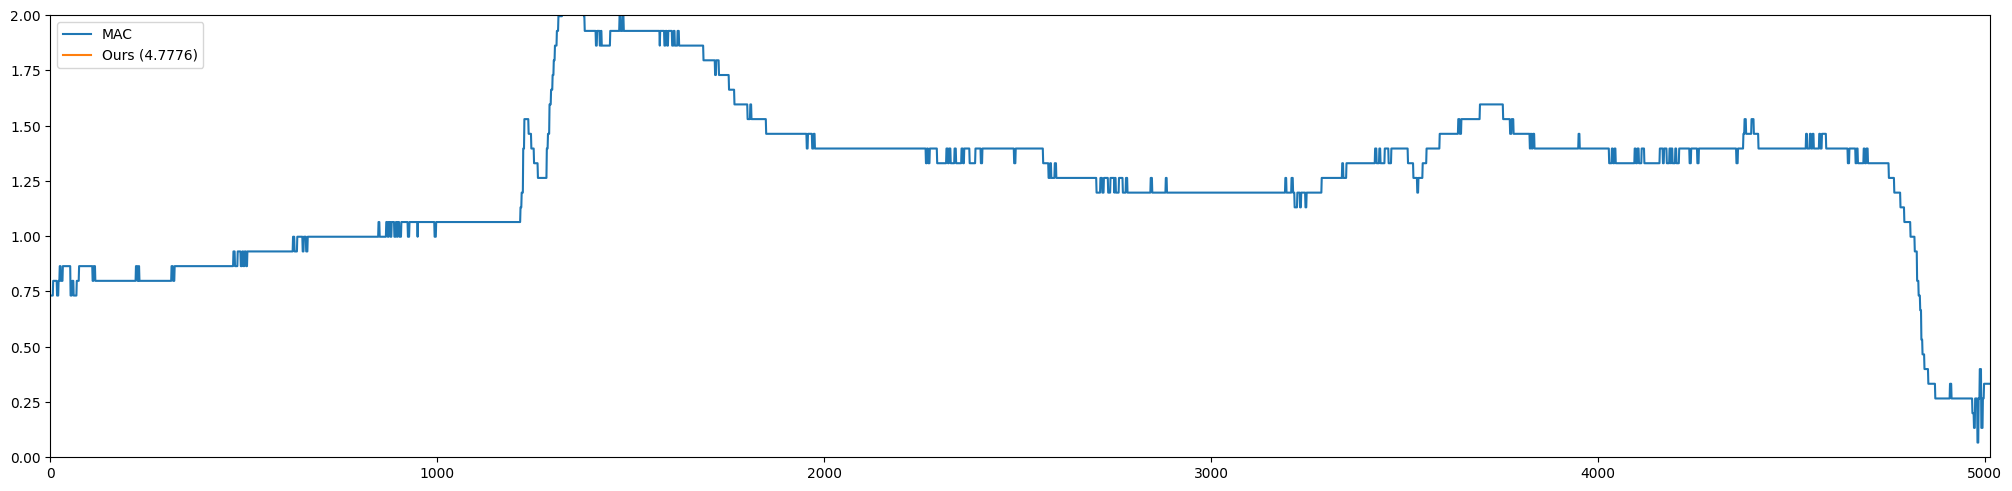

Total MAE=3.9884, CaseID 24, MAE=4.0303


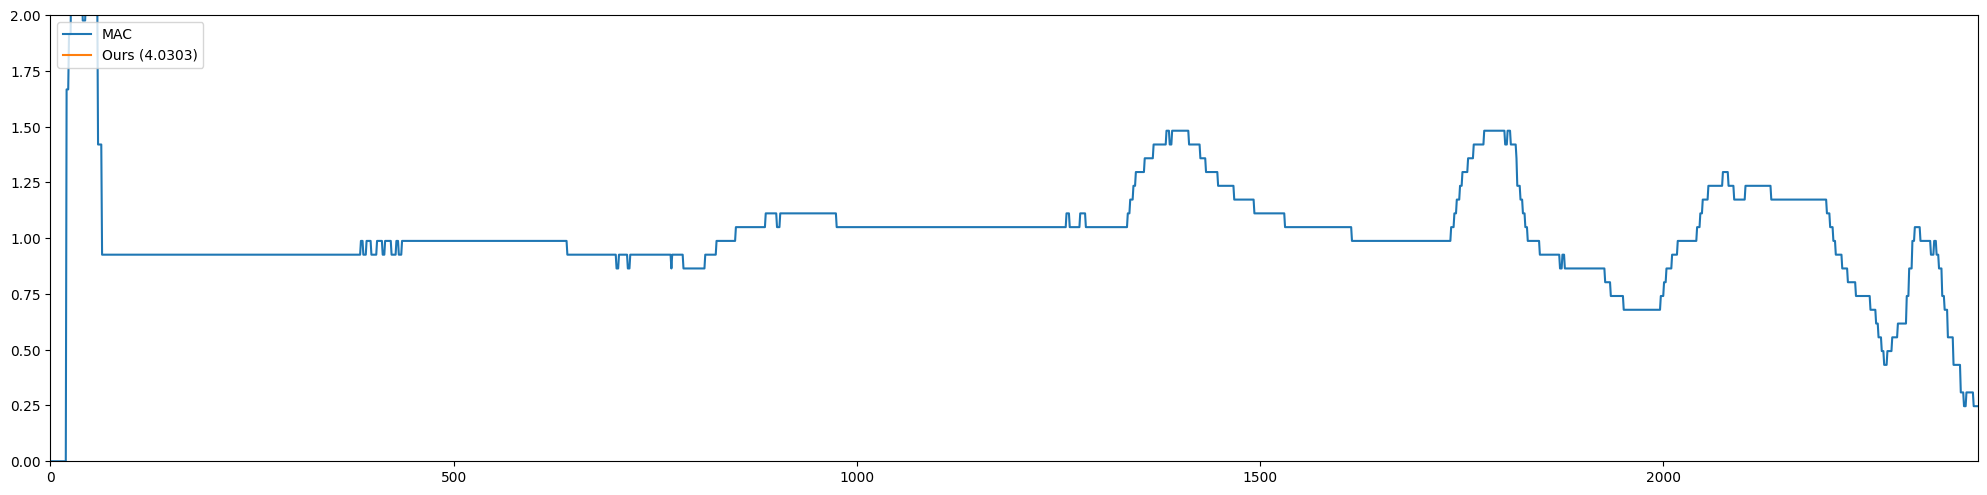

Total MAE=3.9884, CaseID 25, MAE=3.8893


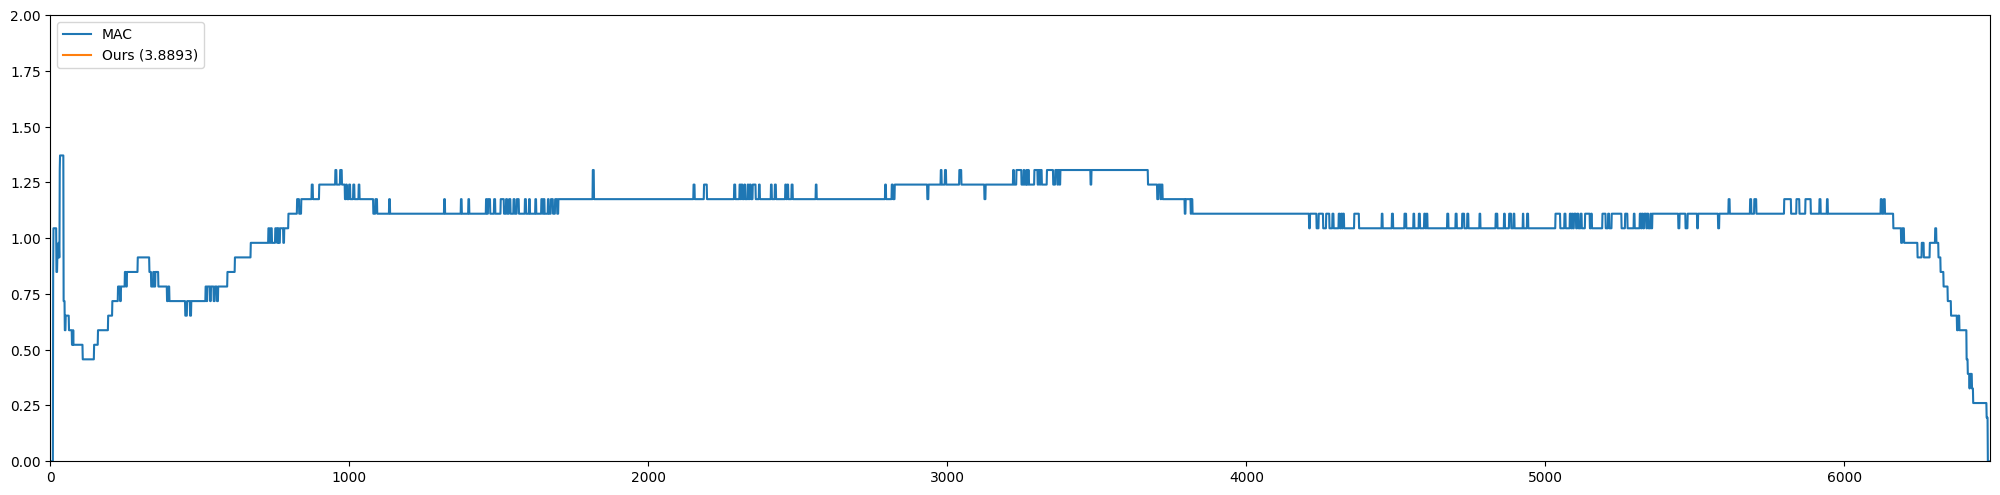

Total MAE=3.9884, CaseID 27, MAE=5.0059


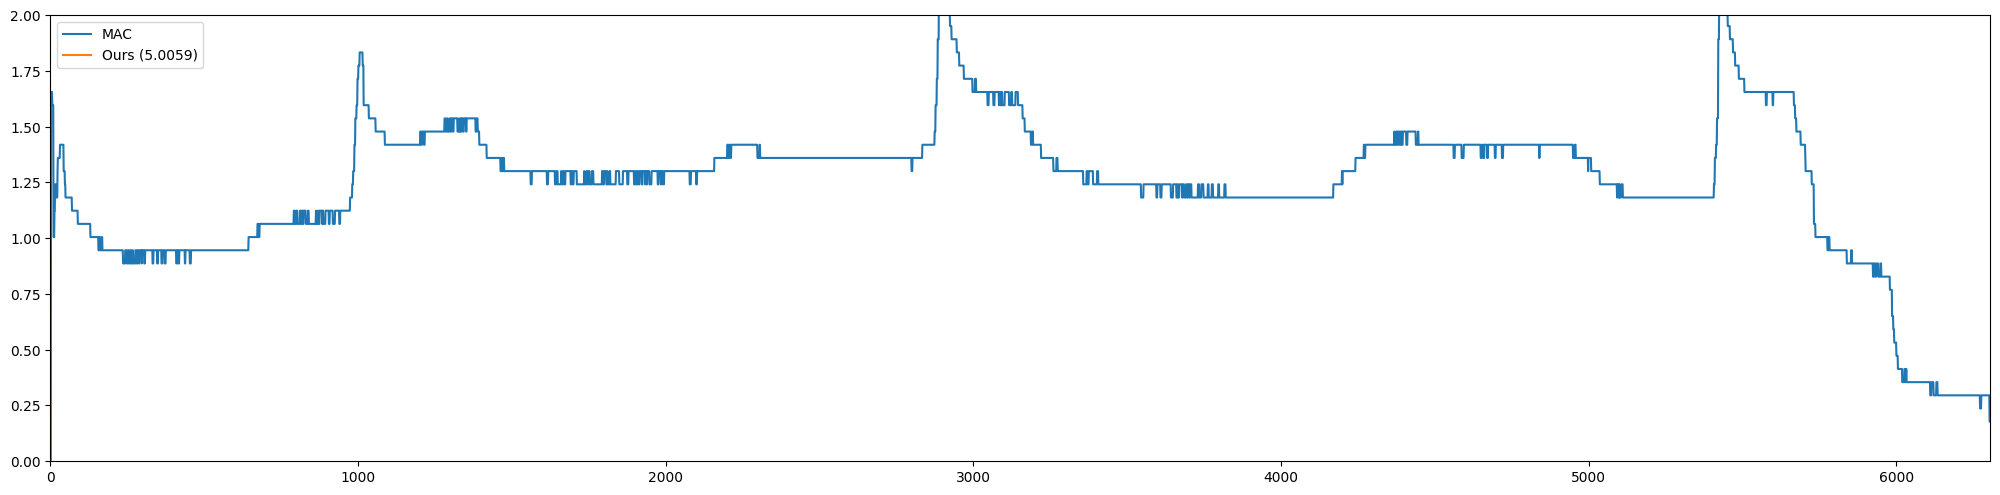

Total MAE=3.9884, CaseID 33, MAE=4.1439


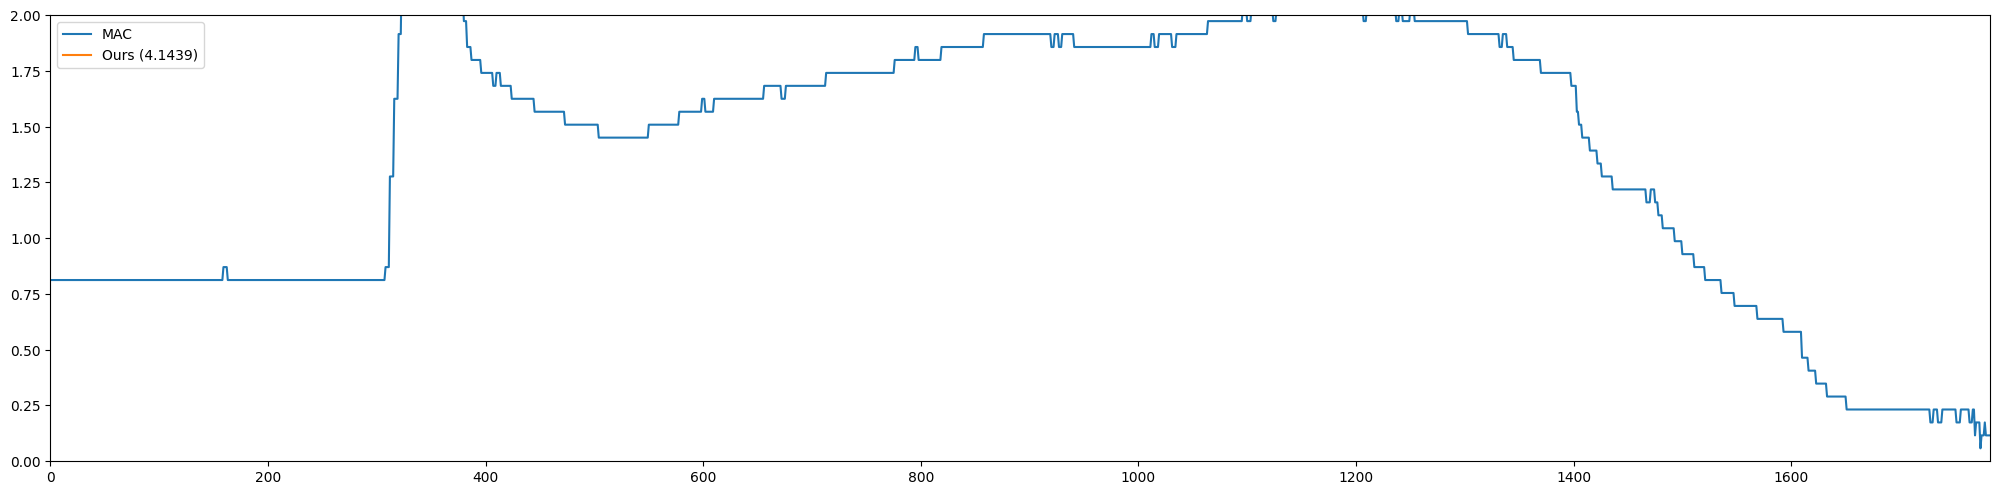

Total MAE=3.9884, CaseID 43, MAE=2.8475


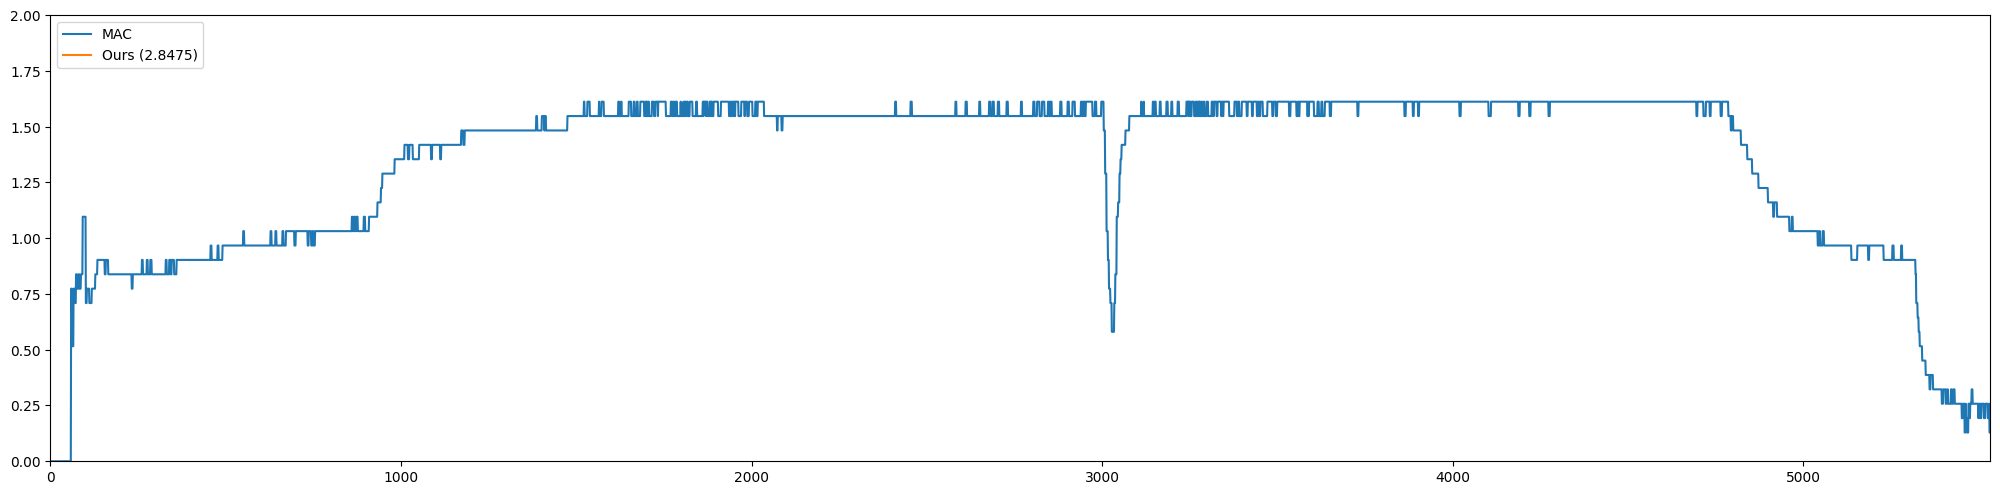

Total MAE=3.9884, CaseID 56, MAE=4.5029


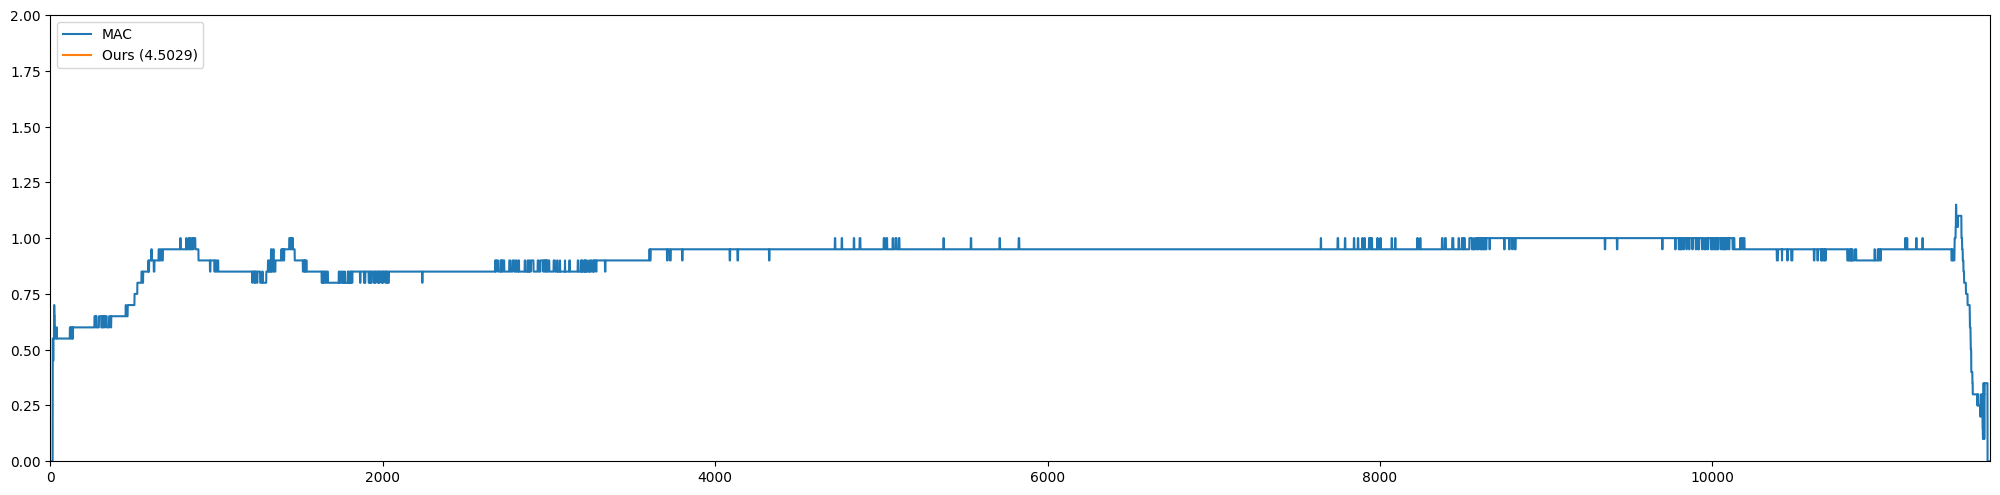

Total MAE=3.9884, CaseID 58, MAE=4.0449


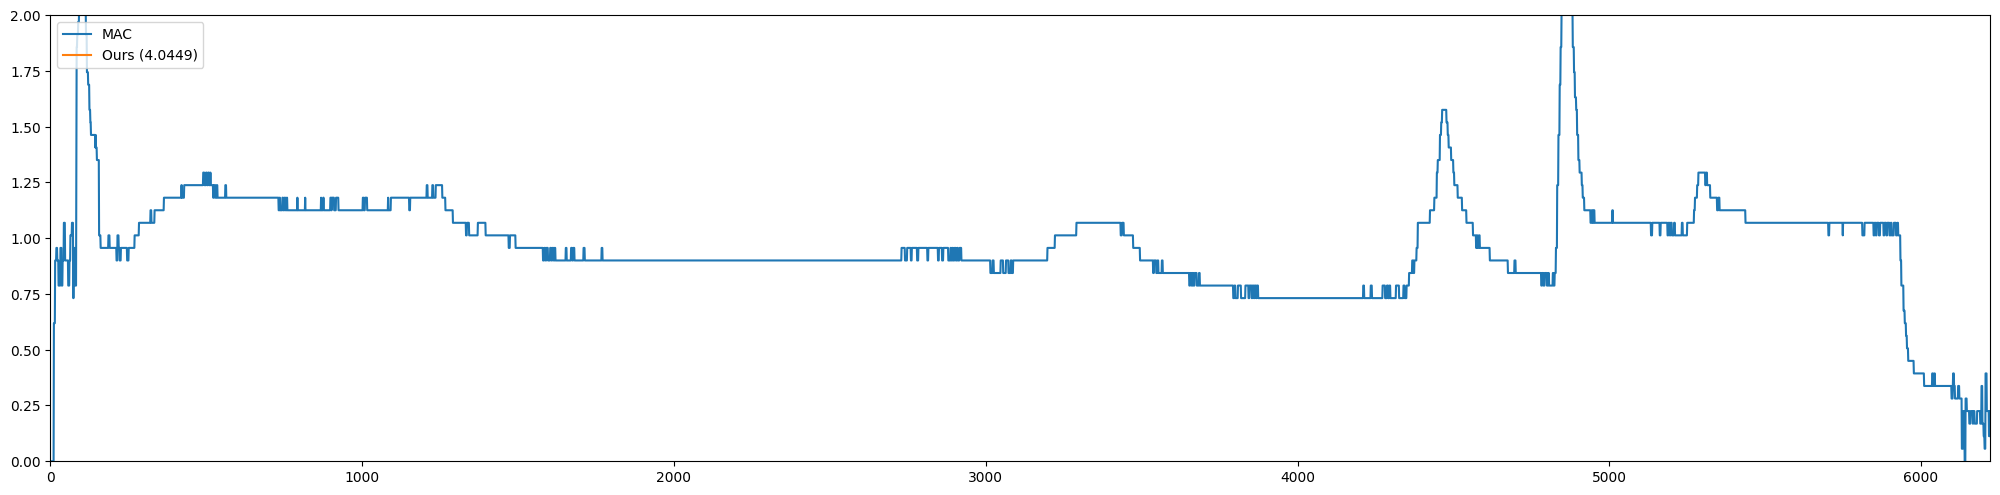

Total MAE=3.9884, CaseID 61, MAE=4.1552


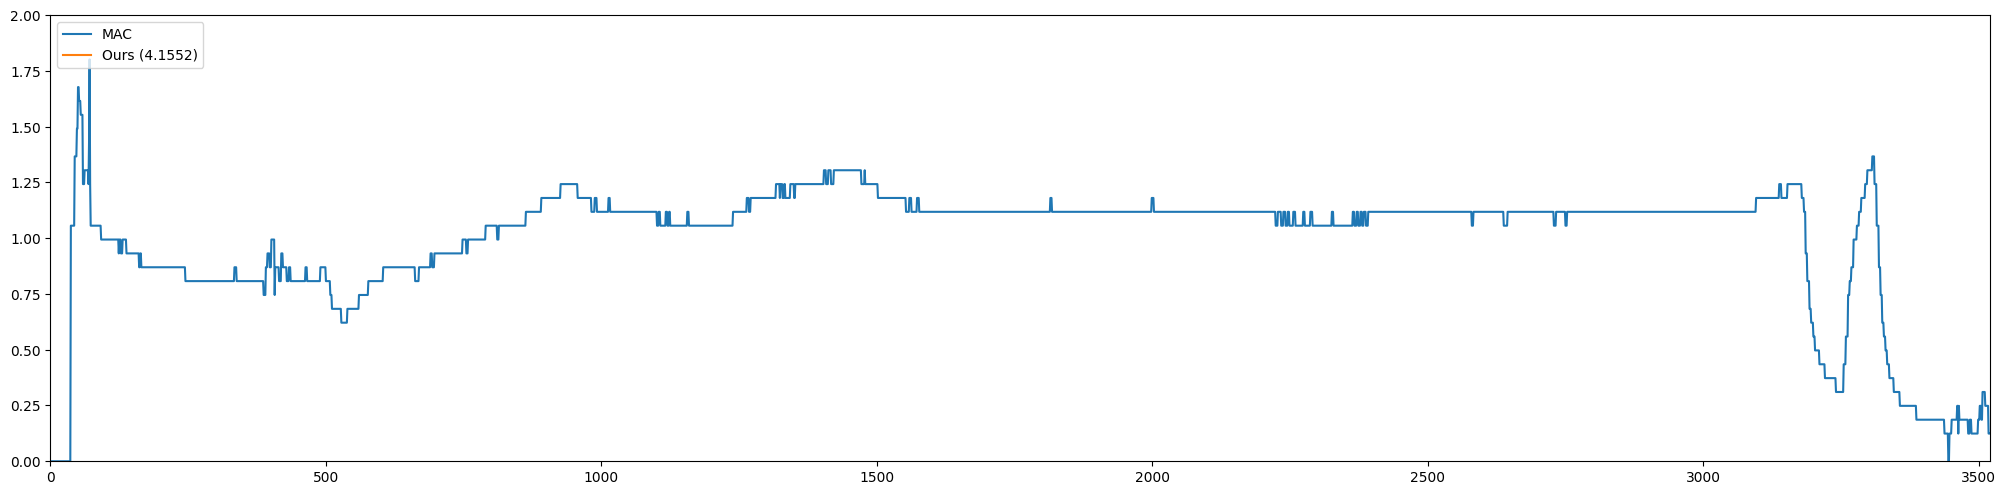

Total MAE=3.9884, CaseID 62, MAE=3.7592


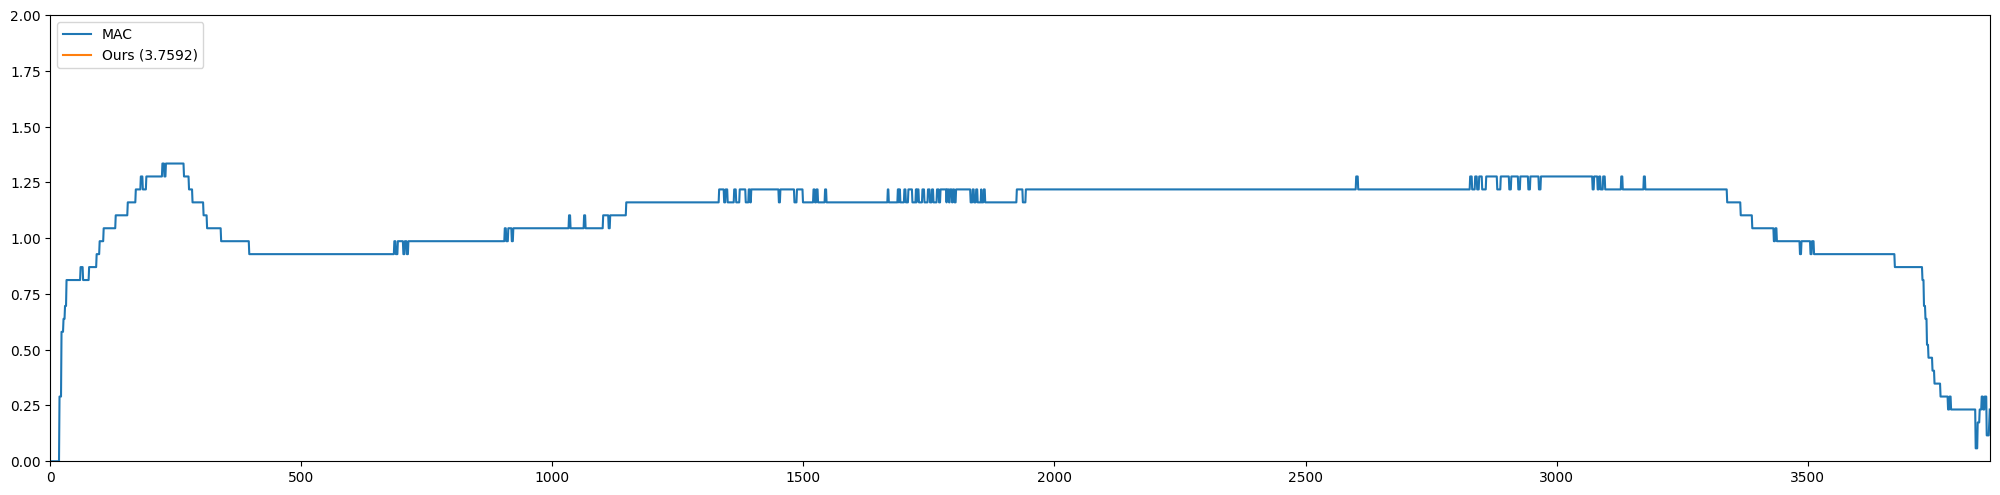

Total MAE=3.9884, CaseID 64, MAE=4.0041


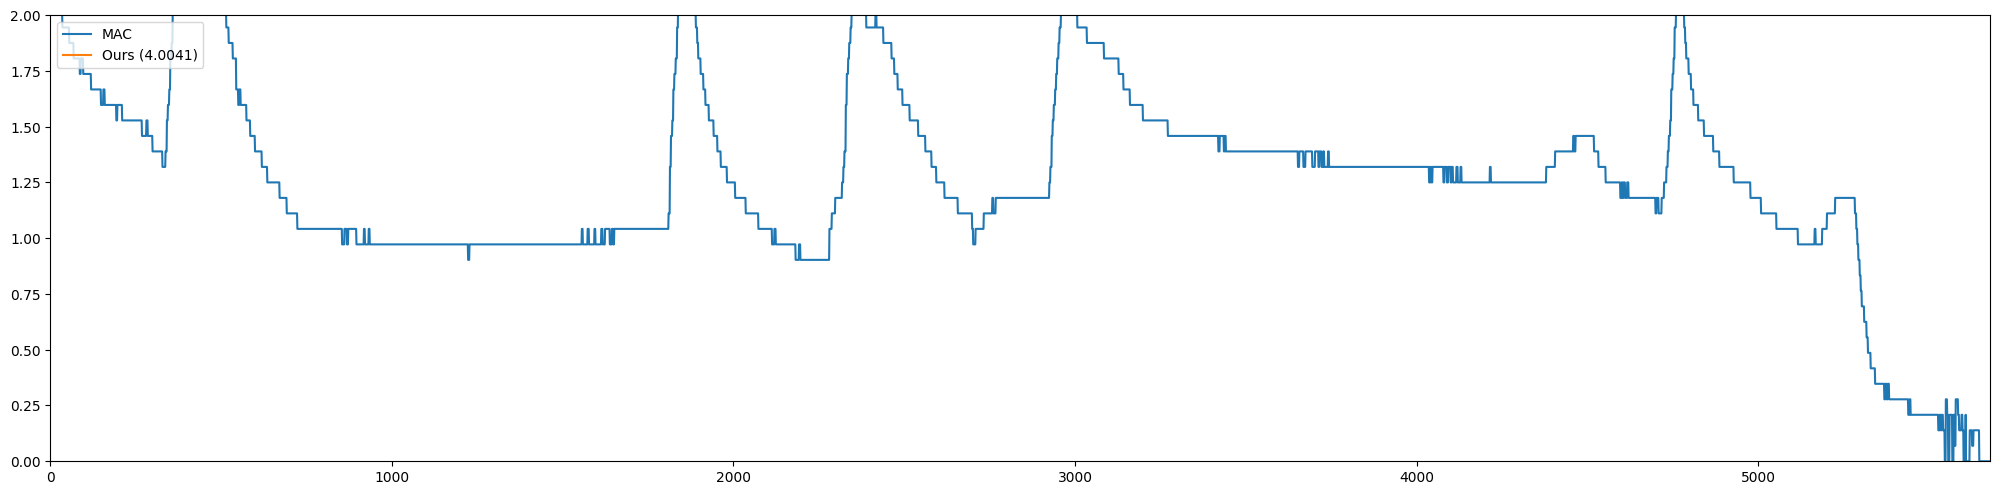

Total MAE=3.9884, CaseID 65, MAE=6.3679


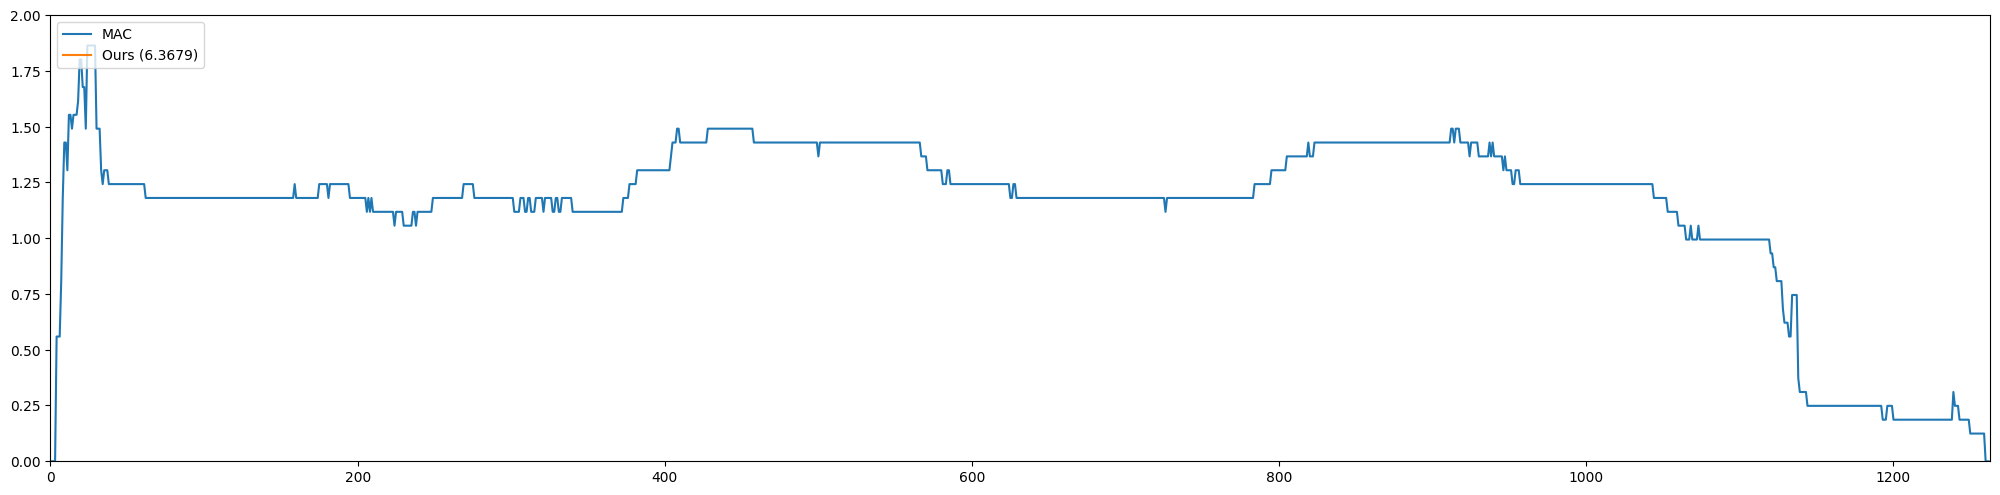

Total MAE=3.9884, CaseID 66, MAE=3.2955


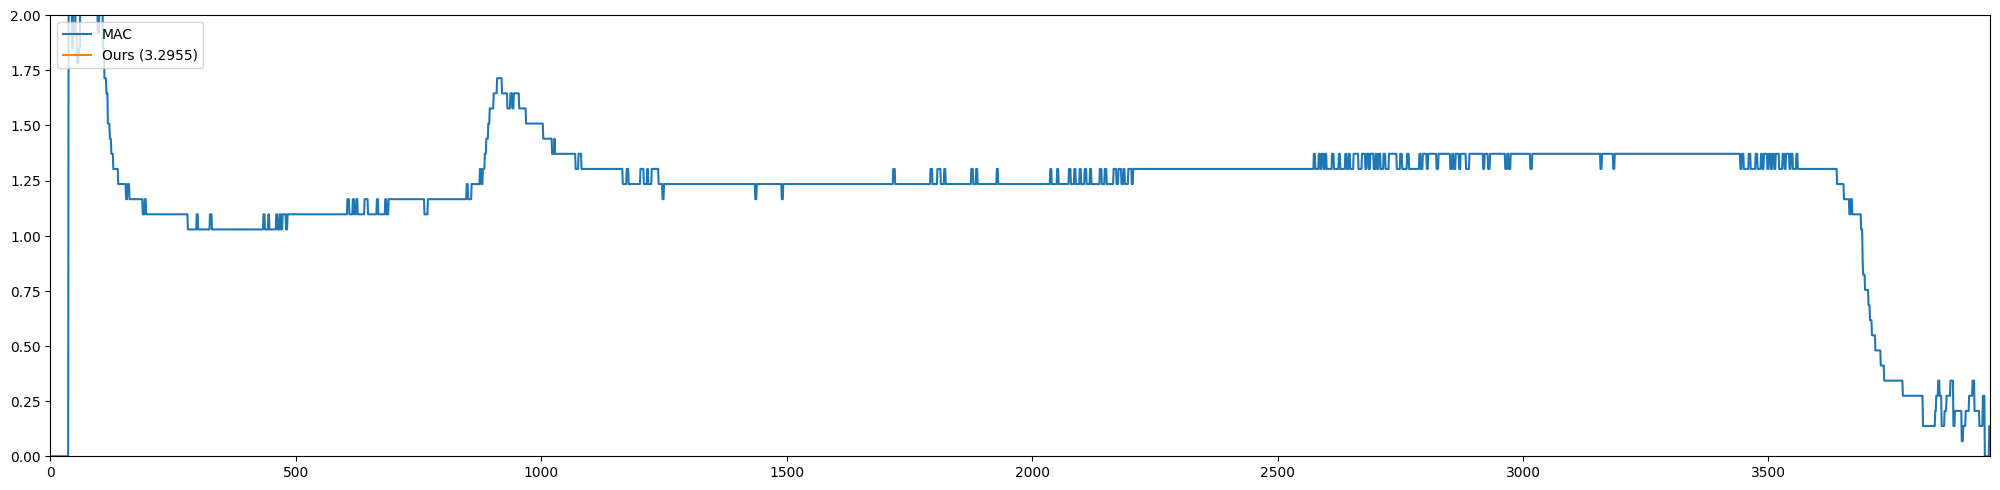

Total MAE=3.9884, CaseID 76, MAE=3.5613


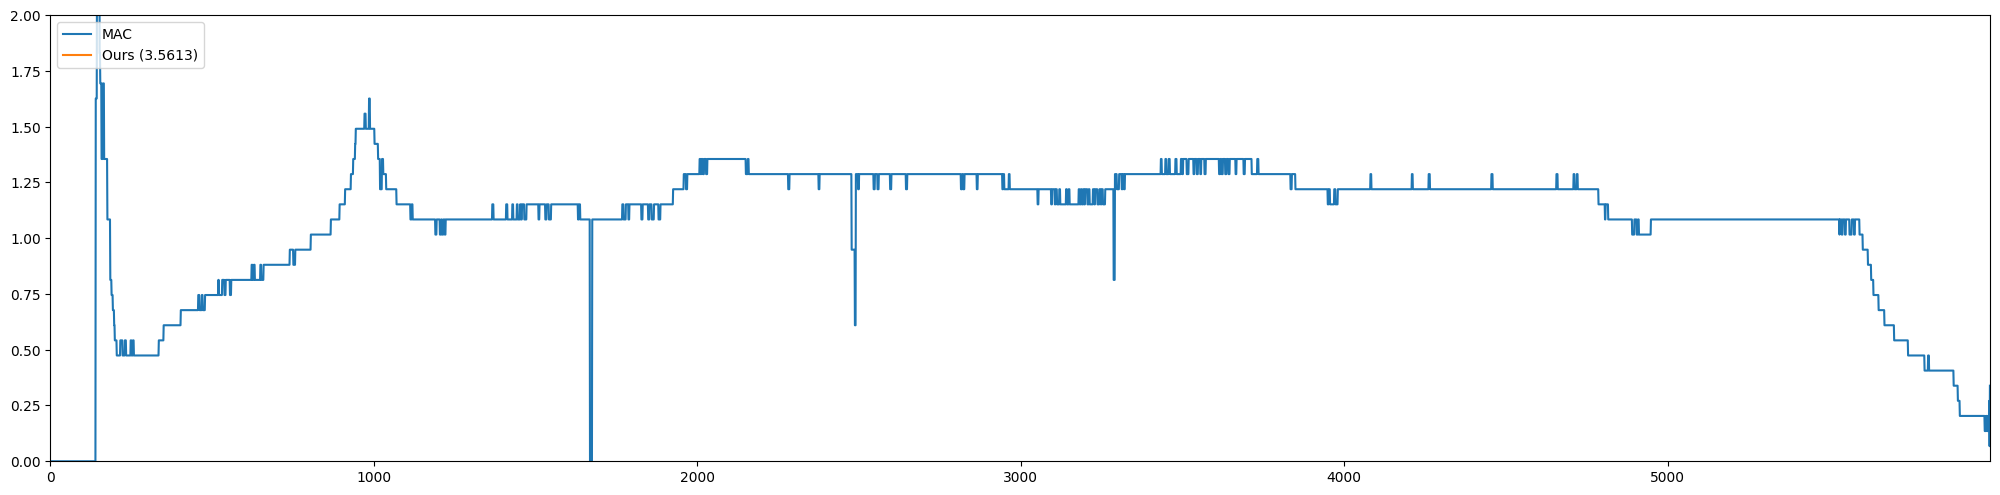

Total MAE=3.9884, CaseID 80, MAE=4.0576


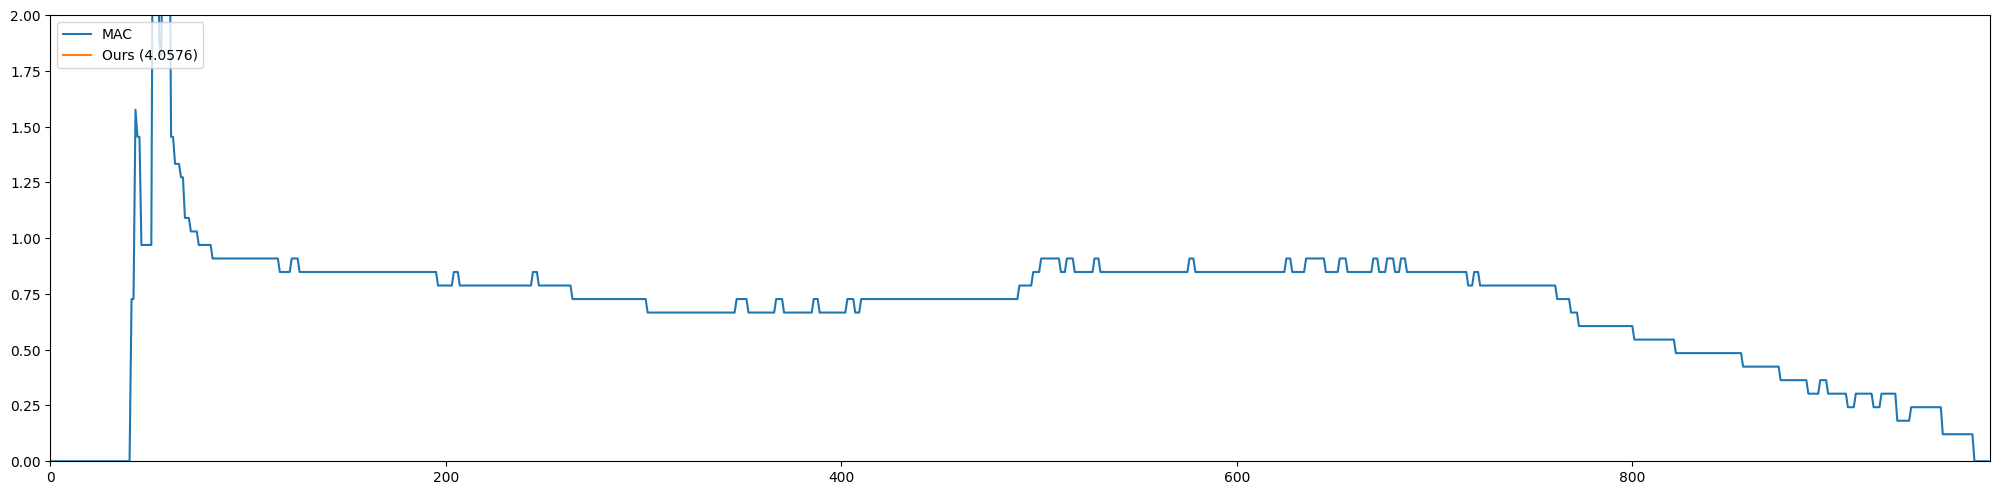

Total MAE=3.9884, CaseID 82, MAE=4.0013


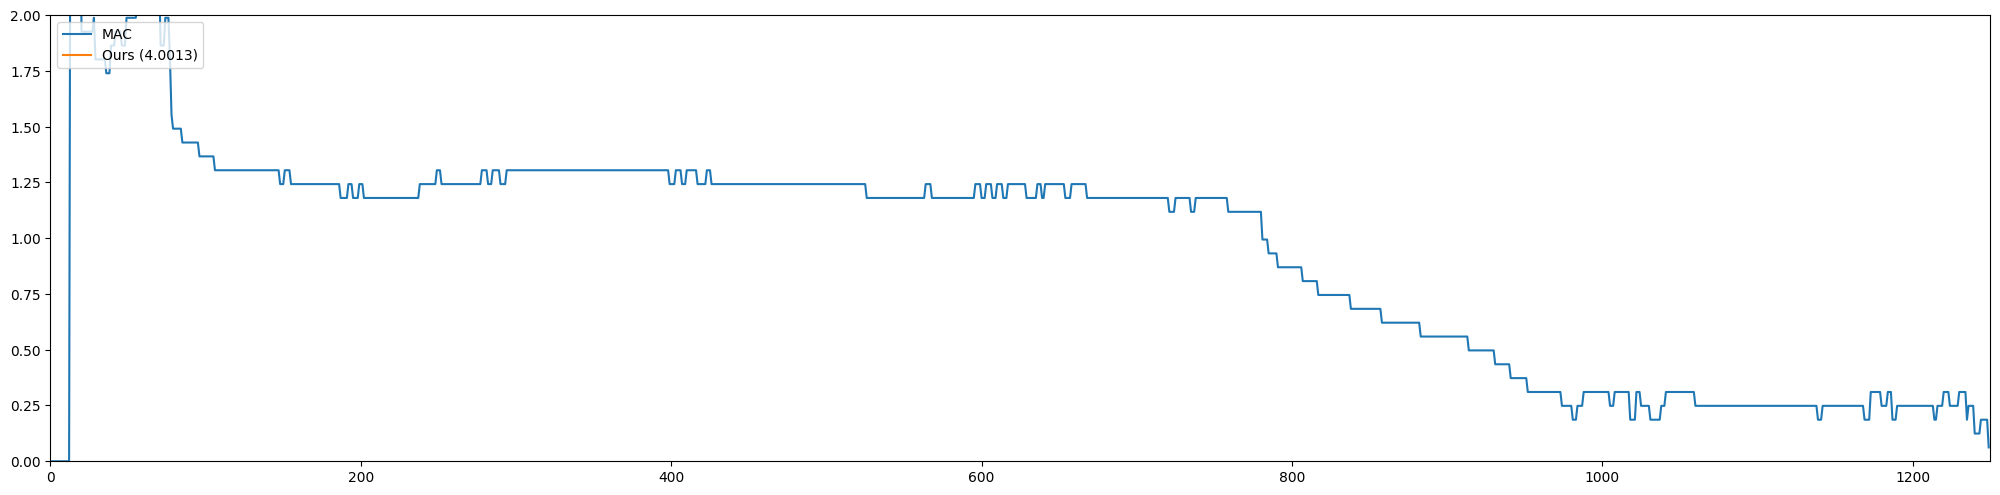

In [ ]:
# plot for each case
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    our_mae = np.mean(np.abs(y_test[case_mask] - pred_test[case_mask]))
    print(f'Total MAE={test_mae:.4f}, CaseID {caseid}, MAE={our_mae:.4f}')

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='MAC')
    plt.plot(t, pred_test[case_mask], label=f'Ours ({our_mae:.4f})')
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.xlim([0, case_len])
    plt.ylim([0, 2])
    plt.show()